In [1]:
%cd src

/Users/kristjan.roosild/OneDrive/kool/AutoML/projekt/automl/src


In [9]:
import gzip
import json

trial_filenames = [
    'trials/autofeat/lightgbm_at_2022-01-13 11-47-40.json.gz',
    'trials/autofeat/xgboost_at_2022-01-13 23-39-10.json.gz',
    'trials/no_autofeat/lightgbm_at_2022-01-13 11-48-14.json.gz',
]

def get_best_loss(filename):
    best_loss = 1.0
    with gzip.open(filename) as fp:
        results = json.load(fp)
        for res in results:
            current_loss = res['result']['loss']
            if current_loss < best_loss:
                best_loss = current_loss
    return best_loss

best_losses = {}
for fn in trial_filenames:
    best_losses[fn]=get_best_loss(fn)


In [10]:
log_filenames = [
    'trials/autofeat/slurm-25868208.out.gz',
    'trials/autofeat/slurm-25885298.out.gz',
    'trials/no_autofeat/slurm-25868200.out.gz',
]

def contains_loss(loss, filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if str(loss) in line:
                return True
        return False

def algo_name(filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if 'LightGBM' in line:
                return 'LightGBM'
        return 'XGBoost'


def get_baseline_auc(filename):
    with gzip.open(filename, mode='rt') as log_containing_baseline:
        for line in log_containing_baseline:
            if 'AUC' in line:
                break
    return float(line.split(' = ')[1].strip())

def autofeat(filename):
    with gzip.open(filename, mode='rt') as log:
        for line in log:
            if 'AutoFeat' in line:
                return 'autofeat'
    return 'no autofeat'

import re
def last_trial(filename):
    with gzip.open(filename, mode='rt') as log:
        for line in reversed(list(log)):
            return int(re.search('\|\s\d+/', line)[0][2:][:-1])


for best_loss in best_losses.values():
    for fn in log_filenames:
        if contains_loss(best_loss, fn):
            print(f'Using {algo_name(fn)} with {autofeat(fn)} the baseline AUC was {get_baseline_auc(fn):.6}. '
                  f'The best AUC achieved with {last_trial(fn)} trials using hyperopt was {1-best_loss:.6}')



Using LightGBM with autofeat the baseline AUC was 0.897471. The best AUC achieved with 202 trials using hyperopt was 0.902188
Using XGBoost with autofeat the baseline AUC was 0.865023. The best AUC achieved with 137 trials using hyperopt was 0.902464
Using LightGBM with no autofeat the baseline AUC was 0.896745. The best AUC achieved with 210 trials using hyperopt was 0.90204


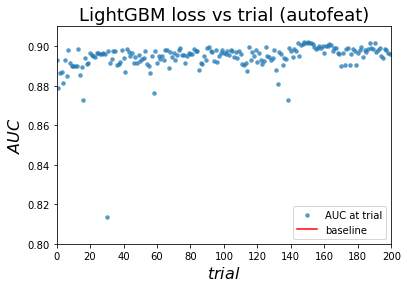

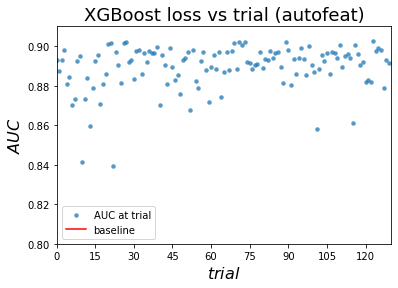

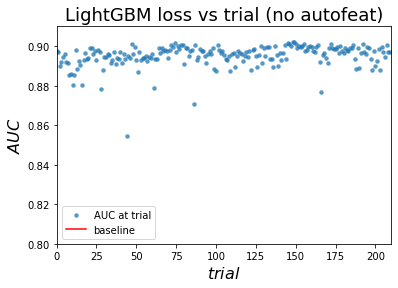

In [11]:
from monitor import Monitor

for jsonfn, best_loss in best_losses.items():
    for fn in log_filenames:
        if contains_loss(best_loss, fn):
            title = f'{algo_name(fn)} loss vs trial ({autofeat(fn)})'
            monitor = Monitor(get_baseline_auc(fn), f'trials/{title}')
            with gzip.open(jsonfn) as fp:
                results = json.load(fp)
                monitor.save_trials_auc_graph(results, title, (0.8, 0.91))